# Detector Response Tests

Demonstrate the conversion of neutrino flux at Earth to observed hits in IceCube.

Hit estimates from ASTERIA are compared to equivalent output from the USSR C++ code.

In [1]:
%matplotlib inline

from asteria import config, source #, interactions
from asteria.neutrino import Flavor
from asteria.interactions import Interactions
from asteria.detector import Detector

import astropy.units as u

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Setup styles for Plotting

In [2]:
axes_style =   {            'grid' : 'True',
                       'labelsize' : '20',
                        'labelpad' : '8.0'}

xtick_style =  {       'direction' : 'in',
                       'labelsize' : '14.',
                      'major.size' : '15.',   
                     'major.width' : '1.',
                   'minor.visible' : 'True',
                      'minor.size' : '7.5',
                     'minor.width' : '1.' }

ytick_style =  {       'direction' : 'in',
                       'labelsize' : '14.',
                      'major.size' : '15.',   
                     'major.width' : '1.',
                   'minor.visible' : 'True',
                      'minor.size' : '7.5',
                     'minor.width' : '1.' }

grid_style =   {           'alpha' : '0.75' }
legend_style = {        'fontsize' : '14' }
font_syle =    {            'size' : '16' }
figure_style = {  'subplot.hspace' : '0.05' }

mpl.rc(   'font', **font_syle )
mpl.rc(   'axes', **axes_style )
mpl.rc(  'xtick', **xtick_style )
mpl.rc(  'ytick', **ytick_style )
mpl.rc(   'grid', **grid_style )
mpl.rc( 'legend', **legend_style )
mpl.rc( 'figure', **figure_style )

## Load Configuration

This will load the source configuration from a file.

For this to work, either the user needs to have done one of two things:
1. Run `python setup.py install` in the ASTERIA directory.
2. Run `python setup.py develop` and set the environment variable `ASTERIA` to point to the git source checkout.

If these were not done, the initialization will fail because the paths will not be correctly resolved.

In [3]:
conf = config.load_config('../../data/config/test.yaml')
ccsn = source.initialize(conf)

## Prepare Iterables

Define the range of neutrino energies (`E_nu`) to simulate and the times (`time`) at which to perform the simulation. 

In [4]:
# Define neutrino energy spectrum
E_min = 0.1; E_max = 100.1; dE = 0.1;
Enu = np.arange(E_min, E_max, dE) * u.MeV

# Define post-bounce times at which to evaluate
t_min = -1; t_max = 15; dt = 0.0001;
time = np.arange(t_min, t_max, dt) * u.s

## Compute Charged Particle Spectrum

Compute the number of photons produced by $\nu$ component interactions with charged particles given neutrino flavor and energy. `Interactions` contains a list of the interactions that are simulated. This list may be changed to turn 'off/on' specific interactions

The interactions are as follows:
- `InvBetaTab` : Tabulated inverse beta decay computation by Strumia and Vissani, Phys. Lett. B 564:42, 2003.
  - See Also: `InvBetaPar` : Inverse beta decay parameterization
- `ElectronScatter` : Elastic Neutrino-electron scattering from Marciano and Parsa, J. Phys. G 29:2969, 2003.
- `Oxygen16CC` : $\nu$-$^{16}O$ charged current interaction, using estimates from Kolbe et al., PRD 66:013007, 2002.
- `Oxygen16NC` : $\nu$-$^{16}O$ neutral current interaction, using estimates from Kolbe et al., PRD 66:013007, 2002.
- `Oxygen18` : $\nu$-$^{18}O$ charged current interaction, using estimates from Kamiokande data from Haxton and Robertson, PRC 59:515, 1999.

These `Interaction` objects may be used to compute the neutrino cross sections and mean energy of the produced lepton, both as a function of neutrino energy. The final state lepton energy has been integrated out. This cross section with a component of $H_2O$ is then scaled as appropriate for a $H_2O$ molecule (IE Electron scattering cross section is scaled by 10, as there are 10 electrons in $H_2O$).

`photon_scaling_factor` is the number of photones per MeV of lepton energy. It is computed by taking product of the data members `photons_per_lepton_MeV` and `p2e_path_ratio` which are respectively, the number of photons emitted per unit lepton path length, and the ratio of positron path length to electron path length in ice.

`photons_per_lepton_MeV` is computed by finding number of photon emitted per unit lepton path length and multiplying it by the lepton path length per MeV. This is done using the Frank-Tamm formula and index of refraction from Price and Bergstrom, AO 36:004181, 1997.

This result estimates the number of photons as a function of neutrino energy. It will have units $m^2$ at the end of this cell but is later scaled by the $r^2$ where $r$ is the progenitor distance, accounting for losses.

NOTE: In the case of `ElectronScatter`, USSR's reported mean energy is the integrated product of the differential cross section and mean energy. ASTERIA computes this quantity and then divides it by the ElectronScatter cross section, so it returns units of MeV. This was done to simplify usage.

In [5]:
photon_spectra = np.zeros( shape=(len(Flavor), Enu.size) )

for nu, flavor in enumerate(Flavor):
    for interaction in Interactions: 
        xs    = interaction.cross_section(flavor, Enu).to(u.m**2).value
        E_lep = interaction.mean_lepton_energy(flavor, Enu).value
        photon_scaling_factor = interaction.photon_scaling_factor(flavor).to( 1/u.MeV).value
        
        
        photon_spectra[nu] +=  xs * E_lep * photon_scaling_factor # u.m**2 
    
    
photon_spectra *= u.m**2 

## Compute Signal per DOM

For each flavor, compute the photonic energy deposition in one $m^3$ of ice, and then scale it to the effective volume of one DOM.

`photonic_energy_per_vol` performs the simulation utilizing numpy broadcasting, and not iteration.

1. Compute the neutrino spectrum from the model Luminosity $L$, Mean neutrino energy $\left< E \right>$ and pinch parameter $\alpha$, which are specified in the SN spectrum file chosen by `config`. This spectrum is a gamma-like p.d.f. of neutrino energy, computed for every time step in `time`. 

2. Multiply the neutrino spectrum and photon spectrum, which are both functions of neutrino energy, then numerically integrate over neutrino energies. This is computed for every time step in `time`.

3. Scale the result of the numerical integration by the neutrino flux and divide by $r^2$ to obtain the photon energy deposition per $m^3$.

This result of `photonic_energy_per_vol` is scaled to the effective volume of a DOM to find the expected signal increase in a single DOM.

__NOTE (03/14/19)__: ASTERIA uses parameters interpolated with a spline to compute the p.d.f, whereas USSR uses linear interpolation. There is high percent error in regions with low flux, and regions at the beginning of the profile where the spline varies more drasticalls ( IE $t \in (-0.25, 0)$s for $\nu_e$ ).

In [6]:
signal_per_DOM = np.zeros( shape=(len(Flavor), time.size) )
icecube_dt = 2e-3 #s

effvol = 0.1654 * u.m**3 / u.MeV #Simple estimation of IceCube DOM Eff. Vol.

for nu, (flavor, photon_spectrum) in enumerate(zip(Flavor, photon_spectra)):
    signal_per_DOM[nu] = effvol * ccsn.photonic_energy_per_vol(time, Enu, flavor, photon_spectrum)


Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed


## Define Helper Functions

Define Functions for plotting, retrieving information from ROOT Files

- `rebin` Reshape the independent variable `var` with resolution `old_binning` and dependent variable `data` (assumed to be numpy array) and return new arrays `var` and `data` with resolution `new_binning`.

- `getUSSRSignal` gets signal from `c_nu_om_signal.root` file whihc is located in the ASTERIA `data` Folders

- `drawComparison` takes USSR and ASTERIA Times and corresponding signals, plots them against eachother and their residuals. Also displays ASTERIA's percent difference from USSR.



In [7]:
def rebin(var, data, old_binning, new_binning):
    step = int(new_binning/old_binning)
    new_size = int(data.size / step)
    
    rebinned_data = np.sum( np.split( data, new_size ), axis=1)
    rebinned_var  = var.value[int(0.5 * step)::step]   
    
    return rebinned_var, rebinned_data

def drawComparison(t, ussr_y, astr_y, flavor, label='', units=''): 
    # Compute difference and percent difference relative to USSR
    diff =  ussr_y - astr_y    
    pct_diff = 100*np.divide( abs(diff), ussr_y, 
                              where=ussr_y>0, 
                              out=np.zeros_like(ussr_y) )
    
    # Compute average percent difference excluding where USSR Reported 0
    avg_pct_diff = np.mean( pct_diff[pct_diff>0] )
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9,6), 
                                   gridspec_kw = {'height_ratios':[5, 1]}, 
                                   sharex=True)
    
    # Plot USSR and ASTERIA against Each other.
    # Plot the difference between the two on the same figure.
    # Plot the percent difference on a subplot with a shared x-axis
    ax1.step( t, ussr_y, label='USSR')
    ax1.step( t, astr_y, label='ASTERIA')
    ax1.step( t, diff, 'k', label = 'Residual: USSR-ASTERIA', alpha=.50)     
    ax2.step( t, pct_diff, 'r', label = r'% Diff. $\bar{\Delta}_\%$'+'={0:4.2f}%'.format(avg_pct_diff))
    
    ax1.set_ylabel( label+' '+units, horizontalalignment='right', y = 1)
    ax2.set_xlabel("t -t$_{bounce}$ [s]", horizontalalignment='right', x = 1)
    ax2.set_yscale('log')
    
    # Group the labels of all lines in one legend object and display on axis 1
    handles, labels = ax1.get_legend_handles_labels()
    handles.append(ax2.get_legend_handles_labels()[0][0])
    labels.append(ax2.get_legend_handles_labels()[1][0])
    legend = ax1.legend( handles, labels )
    
    ax1.set_title( label+' Comparison: '+ flavor.to_tex() )
    # Return figure and axis handles for additional manipulation.
    return fig, (ax1, ax2)
    
def getUSSRdata(file):  
    with open('../../data/USSR/'+file ) as inFile:
        # Get Size of data from first line and initialize.
        line = inFile.readline().strip('#').replace(',','').split()
        t = np.zeros( int(line[1]) )
        data = np.zeros( shape=( int(line[0]), int(line[1])) )
        
        # Clear other lines of header
        inFile.readline() 
        inFile.readline() 
        i = 0
        for line in inFile:
            line = line.split()
            t[i] = float(line[0])
            for nu, item in enumerate(line[1:]):
                data[nu][i] = float(item)
            i+=1
    return t, data

## Plot Expected Signal Increase for Each Flavor
This will compare the signal increase in a seingle DOM caused by each flavor, as it is reported by ASTERIA and USSR. The curve from 0.25 seconds before the core bounce to 1.25 seconds after the core bounce is shown.

__NOTE (03/14/19)__: The time steps have been chosen s.t. USSR and ASTERIA have exaclty the same domain. In other notebooks, the times read from the file in `data\ussr\` are passed to ASTERIA's function. This is not possible for this calculation.

__NOTE (04/22/19)__: The slightly larger disagreement for $\bar{\nu}_e$ May be caused by ASTERIA not subtracting off cherenkov energy, this differs from USSR's implementation. This was previously hidden by an unrelated typo that has since been corrected.

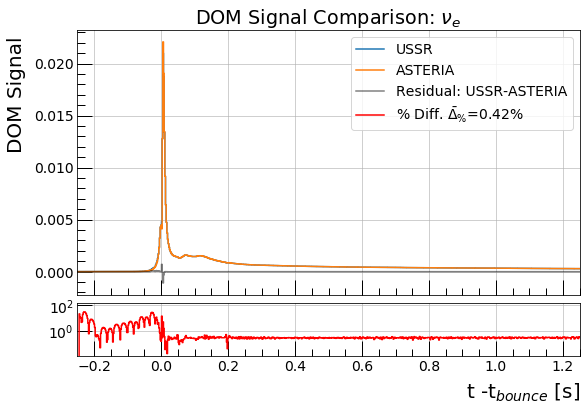

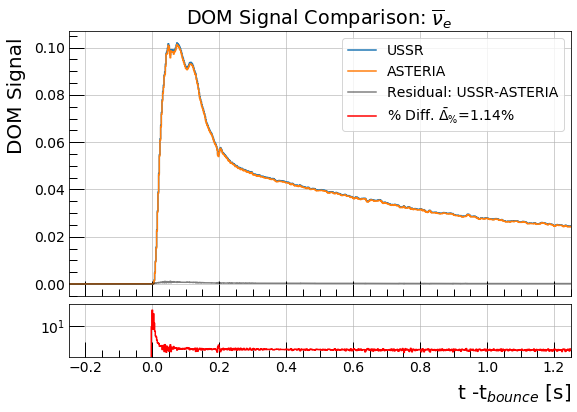

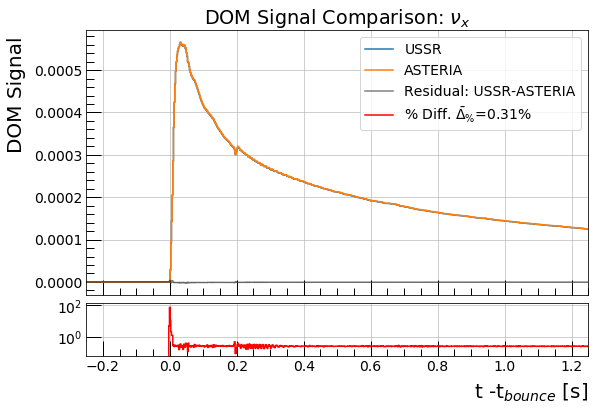

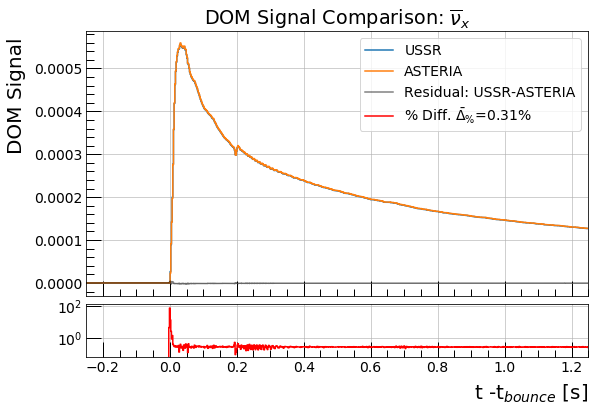

In [8]:
ussrTime, ussrSignal = getUSSRdata('signal_per_dom.txt')

for nu, flavor in enumerate(Flavor):
    astrTime, astrSignal = rebin(time, signal_per_DOM[nu], dt, icecube_dt)
    fig, (ax1, ax2) = drawComparison(astrTime, ussrSignal[nu], astrSignal, flavor, 'DOM Signal')
    ax1.set( xlim=(-0.25, 1.25) )
